# To do:

Structure data so that yelp and foursquare IDs are matched to menus

Combine foursquare and yelp menus

Get prices from Foursquare

In [1]:
import os
import importlib
import pandas as pd
import numpy as np
%matplotlib inline
import pdb
import json
import time
from Kibbeh.src import feature_extract_resto
from Kibbeh.src import API_io
import re
import matplotlib.pyplot as plt
import ast

In [3]:
working_dir = 'C:\\Users\\Chauncey\\Documents\\GitHub\\Kibbeh'
#working_dir = 'C:\\Users\\Me\\Documents\\GitHub\\Kibbeh'
seattle_zips = pd.read_csv(working_dir + '\\seattle_zips.csv')['Zip'].values

In [4]:
# load foursquare restaurants and ratings
with open('fs_restaurant_list.json', 'r') as json_file:
    fs_top_restos = json.load( json_file)
len(fs_top_restos)

3081

In [5]:
# load foursquare menus
with open('fs_restaurant_menus.json', 'r') as json_file:
    fs_menus_rated = json.load( json_file)
len(fs_menus_rated)

332

In [6]:
# load yelp restaurants
with open('yelp_restaurant_list.json', 'r') as json_file:
    yelp_restos = json.load( json_file)
len(yelp_restos)

1000

In [7]:
# load from local json
with open('locu_restaurant_list.json', 'r') as json_file:
    locu_restos = json.load( json_file)
len(locu_restos)

1564

In [8]:
# load
with open('locu_menu_list.json', 'r') as json_file:
    locu_menus = json.load( json_file)
len(locu_menus)

399

# Feature extraction
## Yelp restaurants

In [11]:
yelp_df = feature_extract_resto.feature_extract_yelp_list(yelp_restos)
yelp_df.head(3)

,categories,id,phone,rating,review_count
name,,,,,
Piroshky Piroshky,"[Bakeries, Russian]",piroshky-piroshky-seattle,2064416068,4.5,3235
Paseo,"[Caribbean, Cuban, Sandwiches]",paseo-seattle-3,2065457440,4.5,4099
Umma's Lunch Box,"[Korean, Buffets]",ummas-lunch-box-seattle,2068543166,4.5,184


In [ ]:
pd.scatter_matrix(ganma);

In [ ]:
with open(working_dir + 'yelp_df.csv', 'w', encoding='utf8') as csv_file:
    yelp_df.to_csv(csv_file,  sep=';')

In [ ]:
with open(working_dir + 'yelp_df.csv', 'r', encoding='utf8') as csv_file:
    yelp_df = pd.read_csv(csv_file, sep=';', index_col='name', dtype={'phone':str})
    yelp_df['categories'] = yelp_df['categories'].apply(ast.literal_eval )

## Foursquare restaurant feature extraction

In [9]:
fs_restos_rated = [x for x in fs_top_restos if 'rating' in x['venue'].keys()]
len(fs_restos_rated)

2289

In [10]:
importlib.reload(feature_extract_resto)
fs_resto_df = feature_extract_resto.feature_extract_fs_list(fs_restos_rated)
fs_resto_df.drop_duplicates(inplace=True)
fs_resto_df.head(3)

,categories,checkinsCount,id,phone,rating,tier,tipCount,usersCount
name,,,,,,,,
Burger Express,Burgers,629,4c0c1f2d6071a593a954e232,2538742701,8.8,1,13,320
Señor Taco,Burritos,391,4b6a5e42f964a520a4d32be3,2536619915,8.7,1,12,138
Popeyes Louisiana Kitchen,Fried Chicken,470,4aeb5ad8f964a52050c121e3,2538749740,8.1,1,8,287


C:\Users\Chauncey\Anaconda3\lib\site-packages\pandas\tools\plotting.py:3235: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  "is being cleared", UserWarning)


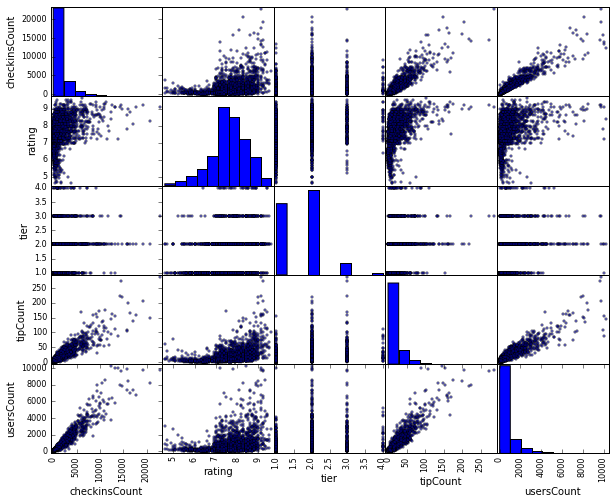

In [12]:
fig, fs_ax = plt.subplots(1, figsize=[10, 8]);
pd.scatter_matrix(fs_resto_df, ax=fs_ax);

## Foursquare menu feature extraction
Each menu json has keys: id, provider, menus

Each menus dict has keys: count (# of "menus"), and items (a LIST of menus, even if theree's just one)

Each element of items has keys: name (of menu), menuId, description, and entries (a dict)

Each entries has keys: count (# of items on menu), and list of items

Each element of items has keys: name, sectionId, description, and MORE entries

Each entries has keys: count, and a list of items

The FINAL items is a list, each element has: description, entryId, and name

In [3]:
import nltk
import Kibbeh.src.feature_extract_menu as fem
from nltk.corpus import stopwords

In [2]:
nltk.download()

showing info http://www.nltk.org/nltk_data/


True

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

In [59]:
cur_menu = fs_menus_rated[0]['menus']
vectorizer = CountVectorizer()
cur_menu_string = json.dumps(cur_menu)
cur_menu_string =re.sub("[^a-zA-Z0-9]", " ", cur_menu_string )
cur_menu_string =re.sub("[0-9]+", " ", cur_menu_string )
vectorizer.fit_transform([cur_menu_string])

<1x401 sparse matrix of type '<class 'numpy.int64'>'
	with 401 stored elements in Compressed Sparse Row format>

In [98]:
menu_list = [json.dumps(menu['menus']) for menu in fs_menus_rated]
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vectorizer = CountVectorizer(stop_words=nltk.corpus.stopwords.words(), analyzer='word',
                             token_pattern=u'(?u)\\b\\w{3,}\\b',
                             min_df= 3 / len(menu_list), max_df = 0.9)
def strip_punct(menu):
    menu =re.sub("[^a-zA-Z0-9]", " ", menu )
    menu =re.sub("[0-9]+", " ", menu )
    return menu
menu_list2 = list(map(strip_punct, menu_list))

In [101]:
v2 = vectorizer.fit_transform(menu_list2)

In [100]:
vectorizer.get_feature_names()[500:]

['cafe',
 'caff',
 'caffe',
 'caffeine',
 'cajun',
 'cake',
 'cakes',
 'cal',
 'calabrian',
 'calamari',
 'calamata',
 'caldo',
 'cali',
 'california',
 'call',
 'called',
 'calorie',
 'calories',
 'calzone',
 'calzones',
 'calzoni',
 'cam',
 'camaron',
 'camarones',
 'cambozola',
 'camomile',
 'campania',
 'campari',
 'campechana',
 'campfire',
 'canada',
 'canadian',
 'candied',
 'candies',
 'candy',
 'cane',
 'cannellini',
 'cannelloni',
 'cannoli',
 'cannot',
 'canoe',
 'canola',
 'cans',
 'cant',
 'cantaloupe',
 'cantucci',
 'cap',
 'cape',
 'capellini',
 'caper',
 'capers',
 'caponata',
 'cappuccino',
 'caprese',
 'capri',
 'capricciosa',
 'caps',
 'captain',
 'carafe',
 'caramba',
 'caramel',
 'caramelized',
 'caraway',
 'carb',
 'carbon',
 'carbonara',
 'carbonated',
 'carbs',
 'cardamom',
 'carefully',
 'caribbean',
 'carlton',
 'carmelized',
 'carmine',
 'carne',
 'carnes',
 'carnitas',
 'carolina',
 'carpaccio',
 'carpano',
 'carraia',
 'carrot',
 'carrots',
 'carry',
 'cart

In [21]:
importlib.reload(fem)
menu_obj = [fem.wordify_json_menu(menu['menus'], stopwords.words()) for menu in fs_menus_rated]
[parsed_fs_menus, num_items, num_sections, num_menus] = zip(*menu_obj)
parsed_fs_menus = list(parsed_fs_menus)
len(parsed_fs_menus)

332

## Locu menu parsing
Each json is a list: first element is the name, second element is a json object of the menu
Each menu is a list of sub_menus
Each sub_menu has keys: menu_name, sections, currency_symbol

In [108]:
# menu[0] has the restaurant name; get all restaurants whose name is in the foursquare dataframe
locu_fs_menus = [menu for menu in locu_menus if menu[0] in fs_resto_df.index]
len(locu_fs_menus)

245

In [109]:
# get the foursquare ids of the locu restaurants
def parse_ids(ids_in):
    if type(ids_in) == str:
        return ids_in
    else:
        return list(ids_in)[0]
locu_fs_ids = [parse_ids(fs_resto_df.loc[ menu[0]]['id'] ) for menu in locu_fs_menus]
len(locu_fs_ids)

245

In [112]:
locu_menu_no_fs_menu = [menu for i, menu in enumerate(locu_fs_menus) if locu_fs_ids[i] not in fs_id]
len(locu_menu_no_fs_menu)

233

In [ ]:
locu_fs_ids = [parse_ids(fs_resto_df.loc[ menu[0]]['id'] ) for menu in locu_menu_no_fs_menu]
len(locu_fs_ids)

In [ ]:
locu_menu_has_fs_id = [menu for i, menu in enumerate(locu_menu_no_fs_menu) if locu_fs_ids[i] in fs_df.id.values]
len(locu_menu_has_fs_id)

In [ ]:
importlib.reload(fem)
menu_obj = [fem.wordify_json_menu(menu, stopwords.words()) for menu in locu_menu_no_fs_menu]
[parsed_locu_menus, num_items, num_sections, num_menus] = zip(*menu_obj)
parsed_locu_menus = list(parsed_locu_menus)
len(parsed_locu_menus)

### Bag of words

In [118]:
combined_menus = parsed_locu_menus
combined_menus.extend(parsed_fs_menus)
len(combined_menus)

NameError: name 'parsed_locu_menus' is not defined

In [116]:
from sklearn.feature_extraction.text import CountVectorizer
menu_vectorizer = CountVectorizer(max_features=3000)

In [117]:
menu_features = menu_vectorizer.fit_transform(combined_menus)
menu_features.shape

NameError: name 'combined_menus' is not defined

In [111]:
fs_id = [menu['id'] for menu in fs_menus_rated]
len(fs_id)

332

In [113]:
fs_menu_df = fs_resto_df.query('id in @fs_id or id in @locu_fs_ids')
fs_menu_df.head(2)

,categories,checkinsCount,id,phone,rating,tier,tipCount,usersCount
name,,,,,,,,
Popeyes Louisiana Kitchen,Fried Chicken,470,4aeb5ad8f964a52050c121e3,2538749740,8.1,1,8,287
Taco Time,Tacos,342,4ba689a7f964a5203e5c39e3,2537351020,7.9,1,5,144


In [114]:
fs_menu_df.shape

(543, 8)

### Gradient boosted trees

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
menu_boost_regressor = GradientBoostingRegressor(n_estimators=50, max_depth = 10, min_samples_leaf=2)

In [ ]:
menu_boost_regressor.fit(menu_features, fs_menu_df['rating'])
menu_boost_regressor.score(menu_features.toarray(), fs_menu_df['rating'])

In [ ]:
importances = menu_boost_regressor.feature_importances_
indices = np.argsort(importances)
menu_feature_names = np.array(menu_vectorizer.get_feature_names() )
list(sorted(zip(importances, menu_feature_names), reverse = True) )[:10]

In [ ]:
first_tree = menu_regressor.estimators_[0][0]
from sklearn.tree import export_graphviz
export_graphviz(first_tree.tree_, out_file='menu_tree.dot', feature_names = menu_feature_names)

In [ ]:
# seed is important
seed_index = np.arange(2000)[menu_feature_names == 'seed']

In [ ]:
seed_feature = menu_features[:,seed_index].toarray()
seed_feature = np.array([x[0] for x in seed_feature] )

In [ ]:
fs_menu_df['rating'].mean()

In [ ]:
fs_menu_df['rating'][seed_feature > 0].mean()

In [ ]:
fs_menu_df['rating'][seed_feature2 > 0][:5]

In [ ]:
# seed is important
risotto_index = np.arange(2000)[menu_feature_names == 'risotto']

In [ ]:
risoto_feature = menu_features[:,risotto_index].toarray()
risoto_feature = np.array([x[0] for x in risoto_feature] )

In [ ]:
fs_menu_df['rating'][risoto_feature>0][:5]

### Elasticnet regression

In [ ]:
from sklearn.linear_model import ElasticNetCV
menu_elastic_net = ElasticNetCV(cv = 2, normalize=True, max_iter=500, n_jobs=2)

In [ ]:
menu_elastic_net.fit(menu_features, fs_menu_df['rating'])

In [ ]:
menu_elastic_net.score(menu_features, fs_menu_df['rating'])

In [ ]:
best_coeff = np.argsort(np.abs(menu_elastic_net.coef_))[-25:]
list(zip(menu_feature_names[best_coeff], menu_elastic_net.coef_[best_coeff]))

### Get all keys in json

In [ ]:
def get_keys(json, json_keys = set()):
    #pdb.set_trace()
    if type(json) == dict:
        for key in json.keys():
            json_keys.add( key )
            json_keys.update(get_keys(json[key]))
    elif type(json) == list:
        for element in json:
            json_keys.update(get_keys(element))
    return json_keys

In [ ]:
all_keys = get_keys(fs_menus_rated)
all_keys